
# More flexibility over the training loop and samplers

Note, you can find the original version of this notebook at [tutorials/18_training_interface.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/18_training_interface.ipynb) in the `sbi` repository.

In the previous tutorials, we showed how `sbi` can be used to train neural networks and sample from the posterior. If you are an `sbi` power-user, then you might want more control over individual stages of this process. For example, you might want to write a custom training loop or more flexibility over the samplers that are used. In this tutorial, we will explain how you can achieve this.

In [37]:
from copy import deepcopy
from typing import Callable

import torch
from torch import eye, ones
from torch.optim import Adam, AdamW
from torch.utils import data

from sbi.analysis import pairplot
from sbi.utils import BoxUniform

As in the previous tutorials, we first define the prior and simulator and use them to generate simulated data: 

In [38]:
seed = 0
torch.manual_seed(seed)

prior = BoxUniform(-3 * ones((2,)), 3 * ones((2,)))


def simulator(theta):
    return theta + torch.randn_like(theta) * 0.1

We can also run checks on the prior and simullator

In [39]:
from sbi.utils.user_input_checks import (
    process_prior,
    process_simulator,
)

prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

In [40]:
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)

Below, we will first describe how you can run `Neural Posterior Estimation (NPE)`. We will attach code snippets for `Neural Likelihood Estimation (NLE)` and `Neural Ratio Estimation (NRE)` at the end.

## Neural Posterior Estimation

First, we have to decide on what `DensityEstimator` to use. In this tutorial, we will use a `Neural Spline Flow` (NSF) taken from the [`nflows`](https://github.com/bayesiains/nflows) package.

In [41]:
from sbi.neural_nets.net_builders import build_nsf

density_estimator = build_nsf(theta, x)

Every `density_estimator` in `sbi` implements at least two methods: `.sample()` and `.loss()`. Their input and output shapes are:


**`density_estimator.loss(input, condition)`:**
```
Args:
    input: `(batch_dim, *event_shape_input)`
    condition: `(batch_dim, *event_shape_condition)`

Returns:
    Loss of shape `(batch_dim,)`
```

**`density_estimator.sample(sample_shape, condition)`:**
```
Args:
    sample_shape: Tuple of ints which indicates the desired number of samples.
    condition: `(batch_dim, *event_shape_condition)`

Returns:
    Samples of shape `(sample_shape, batch_dim, *event_shape_input)`
```

Some `DensityEstimator`s, such as Normalizing flows, also allow to evaluate the `log probability`. In those cases, the `DensityEstimator` also has the following method:

**`density_estimator.log_prob(input, condition)`:**
```
Args:
    input: `(sample_dim, batch_dim, *event_shape_input)`
    condition: `(batch_dim, *event_shape_condition)`

Returns:
    Loss of shape `(sample_dim, batch_dim,)`
```

## Training the density estimator

We can now write our own custom training loop to train the above-generated `DensityEstimator` with early stopping after convergence:

In [42]:
# Define training params
training_batch_size = 200
learning_rate = 5e-4
validation_fraction = 0.1  # 10% of the data will be used for validation
stop_after_epochs = 20  # Stop training after 20 epochs with no improvement
max_num_epochs = 2**31 - 1

We make a dataset out of the data and split into train and test and load into dataloaders

In [43]:
from torch.utils.data.sampler import SubsetRandomSampler

dataset = data.TensorDataset(theta, x)

num_examples = theta.size(0)

# Select random train and validation splits from (theta, x) pairs.
num_training_examples = int((1 - validation_fraction) * num_examples)
num_validation_examples = num_examples - num_training_examples

permuted_indices = torch.randperm(num_examples)
train_indices, val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

train_loader_kwargs = {
    "batch_size": min(training_batch_size, num_training_examples),
    "drop_last": True,
    "sampler": SubsetRandomSampler(train_indices.tolist()),
}
val_loader_kwargs = {
    "batch_size": min(training_batch_size, num_validation_examples),
    "shuffle": False,
    "drop_last": True,
    "sampler": SubsetRandomSampler(val_indices.tolist()),
}

train_loader_kwargs = dict(train_loader_kwargs)
val_loader_kwargs = dict(val_loader_kwargs)

train_loader = data.DataLoader(dataset, **train_loader_kwargs)
val_loader = data.DataLoader(dataset, **val_loader_kwargs)

Here's a training loop similar to the NPE class train function

In [ ]:
optimizer = Adam(list(density_estimator.parameters()), lr=learning_rate)
epoch, val_loss = 0, float("Inf")

best_val_loss = float("Inf")

converged = False

while epoch <= max_num_epochs and not converged:
    # Train for a single epoch.
    density_estimator.train()
    train_loss_sum = 0
    for batch in train_loader:
        optimizer.zero_grad()
        theta_batch, x_batch = (
            batch[0],
            batch[1],
        )

        train_losses = density_estimator.loss(theta_batch, x_batch)
        train_loss = torch.mean(train_losses)
        train_loss_sum += train_losses.sum().item()

        train_loss.backward()

        optimizer.step()

    epoch += 1

    train_loss_average = train_loss_sum / (
        len(train_loader) * train_loader.batch_size
    )

    # Calculate validation performance.
    density_estimator.eval()
    val_loss_sum = 0

    with torch.no_grad():
        for batch in val_loader:
            theta_batch, x_batch = (batch[0], batch[1])

            val_losses = density_estimator.loss(
                theta_batch,
                x_batch,
            )
            val_loss_sum += val_losses.sum().item()

    # Take mean over all validation samples.
    val_loss = val_loss_sum / (len(val_loader) * val_loader.batch_size)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_since_last_improvement = 0
        best_model_state_dict = deepcopy(density_estimator.state_dict())
    else:
        epochs_since_last_improvement += 1

    # If no validation improvement over many epochs, stop training.
    if epochs_since_last_improvement > stop_after_epochs - 1:
        density_estimator.load_state_dict(best_model_state_dict)
        converged = True
        print(f'Neural network successfully converged after {epoch} epochs')

Neural network successfully converged after 129 epochs


In [45]:
x_o = torch.as_tensor([[1.0, 1.0]])
print(f"Shape of x_o: {x_o.shape}            # Must have a batch dimension")

samples = density_estimator.sample((1000,), condition=x_o).detach()
print(
    f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension."
)

samples = samples.squeeze(dim=1)
print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

Shape of x_o: torch.Size([1, 2])            # Must have a batch dimension
Shape of samples: torch.Size([1000, 1, 2])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([1000, 2])     # Removed batch dimension.


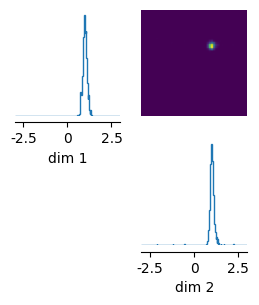

In [46]:
pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3));

We perform a sanity check to compare to the inbuilt training function

In [47]:
from sbi.inference import NPE

torch.manual_seed(seed)

inference = NPE(prior=prior, density_estimator='nsf')

inference = inference.append_simulations(theta, x)
density_estimator_npe = inference.train()

 Neural network successfully converged after 128 epochs.

In [48]:
x_o = torch.as_tensor([[1.0, 1.0]])
print(f"Shape of x_o: {x_o.shape}            # Must have a batch dimension")

samples = density_estimator_npe.sample((1000,), condition=x_o).detach()
print(
    f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension."
)

samples = samples.squeeze(dim=1)
print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

Shape of x_o: torch.Size([1, 2])            # Must have a batch dimension
Shape of samples: torch.Size([1000, 1, 2])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([1000, 2])     # Removed batch dimension.


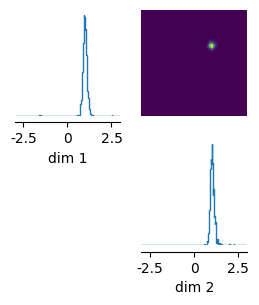

In [49]:
pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3));

Given this trained `density_estimator`, we can already generate samples from the posterior given observations (but we have to adhere to the shape specifications of the `DensityEstimator` explained above:

### Wrapping as a `DirectPosterior`

You can also wrap the `DensityEstimator` as a `DirectPosterior`. The `DirectPosterior` is also returned by  `inference.build_posterior` and you have already learned how to use it in the [introduction tutorial](https://sbi-dev.github.io/sbi/dev/tutorials/00_getting_started/) and the [amortization tutotrial](https://sbi-dev.github.io/sbi/dev/tutorials/01_gaussian_amortized/). It adds the following functionality over the raw `DensityEstimator`:

- automatically reject samples outside of the prior bounds  
- compute the Maximum-a-posteriori (MAP) estimate



In [50]:
from sbi.inference.posteriors import DirectPosterior

posterior = DirectPosterior(density_estimator, prior)

In [51]:
print(f"Shape of x_o: {x_o.shape}")
samples = posterior.sample((1000,), x=x_o)
print(f"Shape of samples: {samples.shape}")

Shape of x_o: torch.Size([1, 2])


Drawing 1000 posterior samples: 1096it [00:00, 27444.85it/s]            

Shape of samples: torch.Size([1000, 2])


Note: For the `DirectPosterior`, the batch dimension is optional, i.e., it is possible to sample for multiple observations simultaneously. Use `.sample_batch` in that case.

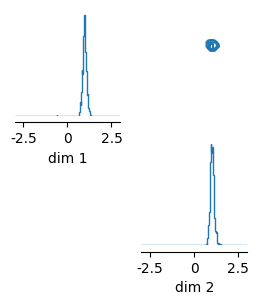

In [52]:
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3), upper="contour")

### Custom Data Loaders

One helpful advantage of having access to the training loop is that you can now use your own DataLoaders during training of the density estimator. In this fashion, larger datasets can be used as input to `sbi` where `x` is potentially an image or something else. While this will require [embedding the input data](https://sbi-dev.github.io/sbi/latest/tutorials/04_embedding_networks/), a more fine grained control over loading the data is possible and allows to manage the memory requirement during training.

First, we build a Dataset that complies with the `torch.util.data.Dataset` API. Note, the class below is meant for illustration purposes. In practice, this class can also read the data from disk etc.


In [53]:
class NPEData(torch.utils.data.Dataset):
    def __init__(
        self,
        num_samples: int,
        prior: torch.distributions.Distribution,
        simulator: Callable,
        seed: int = 44,
    ):
        super().__init__()

        torch.random.manual_seed(seed)  # will set the seed device wide
        self.prior = prior
        self.simulator = simulator

        self.theta = prior.sample((num_samples,))
        self.x = simulator(self.theta)

    def __len__(self):
        return self.theta.shape[0]

    def __getitem__(self, index: int):
        return self.theta[index, ...], self.x[index, ...]

We can now proceed to create a DataLoader and conduct our training loop as illustrated above.

In [54]:
train_data = NPEData(num_samples=2048, prior=prior, simulator=simulator)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)

For sake of demonstration, let's create another estimator using a masked autoregressive flow (maf). For this, we create a second dataset and use only parts of the data to construct the maf estimator.

In [55]:
from sbi.neural_nets.net_builders import build_maf

dummy_data = NPEData(64, prior, simulator, seed=43)
dummy_loader = torch.utils.data.DataLoader(dummy_data, batch_size=4)
dummy_theta, dummy_x = next(iter(dummy_loader))
maf_estimator = build_maf(dummy_theta, dummy_x)

In [56]:
optw = AdamW(list(maf_estimator.parameters()), lr=5e-4)
num_epochs = 100

for ep in range(num_epochs):
    for _, (theta_batch, x_batch) in enumerate(train_loader):
        optw.zero_grad()
        losses = maf_estimator.loss(theta_batch, condition=x_batch)
        loss = torch.mean(losses)
        loss.backward()
        optw.step()
    if ep % 10 == 0:
        print("last loss", loss.item())

last loss 4.492389678955078
last loss -1.2831014394760132
last loss -1.5764975547790527
last loss -1.6195346117019653
last loss -1.643930196762085
last loss -1.6492973566055298
last loss -1.6488878726959229
last loss -1.6473501920700073
last loss -1.651580572128296
last loss -1.6809768676757812


In [57]:
# let's compare the trained estimator to the NSF from above
samples = maf_estimator.sample((1000,), condition=x_o).detach()
print(
    f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension."
)

samples = samples.squeeze(dim=1)
print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

Shape of samples: torch.Size([1000, 1, 2])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([1000, 2])     # Removed batch dimension.


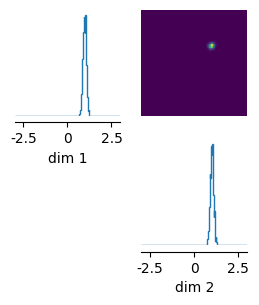

In [58]:
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))

## Neural Likelihood Estimation

The workflow for Neural Likelihood Estimation is very similar. Unlike for NPE, we have to sample with MCMC (or variational inference) though, so we will build an `MCMCPosterior` after training:

In [59]:
from sbi.inference.posteriors import MCMCPosterior
from sbi.inference.potentials import likelihood_estimator_based_potential

In [60]:
# Note that the order of x and theta are reversed in comparison to NPE.
density_estimator = build_nsf(x, theta)

# Training loop.
opt = Adam(list(density_estimator.parameters()), lr=5e-4)
for _ in range(200):
    opt.zero_grad()
    losses = density_estimator.loss(x, condition=theta)
    loss = torch.mean(losses)
    loss.backward()
    opt.step()

# Build the posterior.
potential, tf = likelihood_estimator_based_potential(density_estimator, prior, x_o)
posterior = MCMCPosterior(
    potential,
    proposal=prior,
    theta_transform=tf,
    num_chains=50,
    thin=1,
    method="slice_np_vectorized",
)

Running vectorized MCMC with 50 chains: 100%|██████████| 13500/13500 [00:35<00:00, 376.22it/s]


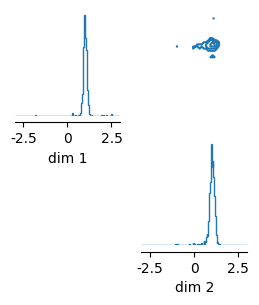

In [61]:
samples = posterior.sample((1000,), x=x_o)
pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3), upper="contour");

## Neural Ratio Estimation

Finally, for NRE, at this point, you have to implement the loss function yourself:

In [62]:
from sbi import utils as utils
from sbi.inference.potentials import ratio_estimator_based_potential
from sbi.neural_nets.net_builders import build_resnet_classifier

In [63]:
net = build_resnet_classifier(x, theta)

In [64]:
opt = Adam(list(net.parameters()), lr=5e-4)


def classifier_logits(net, theta, x, num_atoms):
    batch_size = theta.shape[0]
    repeated_x = utils.repeat_rows(x, num_atoms)
    probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
    choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
    contrasting_theta = theta[choices]
    atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
        batch_size * num_atoms, -1
    )
    return net(atomic_theta, repeated_x)


num_atoms = 10
for _ in range(300):
    opt.zero_grad()
    batch_size = theta.shape[0]
    logits = classifier_logits(net, theta, x, num_atoms=num_atoms)
    logits = logits.reshape(batch_size, num_atoms)
    log_probs = logits[:, 0] - torch.logsumexp(logits, dim=-1)
    loss = -torch.mean(log_probs)
    loss.backward()
    opt.step()

In [65]:
potential, tf = ratio_estimator_based_potential(net, prior, x_o)
posterior = MCMCPosterior(
    potential,
    proposal=prior,
    theta_transform=tf,
    num_chains=100,
    thin=1,
    method="slice_np_vectorized",
)

Running vectorized MCMC with 100 chains: 100%|██████████| 26000/26000 [00:06<00:00, 3911.36it/s]


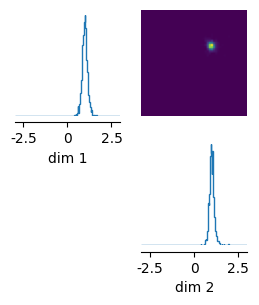

In [66]:
samples = posterior.sample((1000,), x=x_o)
pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3));